# YouTube Trending Video - Sentiment Analysis


*The dataset  GB_youtube_trending_data.csv is a daily record of the top trending YouTube videos since August 2021. 2020.
The idea is to analyse if videos with Tag generate higher view compare with non tags, and the proportion of likes.*

It was collected using the YouTube API. YouTube maintains a list of the top trending videos on the platform to get yearly top-trending videos.*

*This dataset includes months of August 2020 to February 2021 (and counting) of data on daily trending YouTube videos. Data is related to Great Britain channels with up to 200 listed trending videos per day.The data includes the video title, channel title, publish time, tags, view counts, likes and dislikes, description,channel Id, comment count and view more.*

**Reference**

*Kaggle, 2021. Datasets: YouTube Trending Video Dataset (updated daily).[online] Available at:https://www.kaggle.com/rsrishav/youtube-trending-video-dataset?select=GB_youtube_trending_data.csv, [Accessed February 27th 2021].*



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

#Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Build Functions

In [2]:
#define function to drop duplicate titles, keeping first or most recent trending date
def  remove_duplicate_title(data,kp):
    """
    drop duplicate titles
    and keep the data from
    the last or first posted date
    use 'first' or 'last' as kp
    """
    clean_data= data.sort_values('trending_date', ascending=True).drop_duplicates('title', keep=kp)
    clean_data= clean_data.sort_values('trending_date', ascending=False)
    return(clean_data)

In [3]:
youtube = pd.read_csv('GB_youtube_trending_data.csv', parse_dates=['publishedAt','trending_date'])

youtube.tail(3)

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
38993,Ev_m2BEChsw,Josh Asks Nessa Her Biggest Secrets..,2021-02-20 17:01:16+00:00,UCQC2re4ieW_x_cHs2--uJTg,Griffin Johnson,24,2021-02-26 00:00:00+00:00,[None],1105044,79645,728,1415,https://i.ytimg.com/vi/Ev_m2BEChsw/default.jpg,False,False,THIS VIDEO GETS DEEP INTO THEIR RELATIONSHIP.....
38994,RL78tuBGWe0,Harry and Jamie Redknapp's 'Get Out Of Me Ear'...,2021-02-20 20:09:30+00:00,UCNsXOvE8mBbs0r5ijYkHVWQ,Ant & Dec's Saturday Night Takeaway,24,2021-02-26 00:00:00+00:00,ant and dec undercover|saturday night takeaway...,109647,1923,30,0,https://i.ytimg.com/vi/RL78tuBGWe0/default.jpg,True,False,Father and son duo Harry and Jamie Redknapp mu...
38995,GGko6uK-Fik,The BRAND NEW MST mk2 - is this the ultimate F...,2021-02-20 17:30:19+00:00,UCf2rpBEOs5jglV2YxmKD8hw,The Late Brake Show,2,2021-02-26 00:00:00+00:00,ford escort twin cam|mk1 escort lotus twin cam...,246707,11845,77,1593,https://i.ytimg.com/vi/GGko6uK-Fik/default.jpg,False,False,When are classic Escorts not classic? When the...


In [4]:
print("Summary of the basic information about this DataFrame and its data with null count excluded:")
youtube.info(verbose = True)

Summary of the basic information about this DataFrame and its data with null count excluded:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38996 entries, 0 to 38995
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           38996 non-null  object             
 1   title              38996 non-null  object             
 2   publishedAt        38996 non-null  datetime64[ns, UTC]
 3   channelId          38996 non-null  object             
 4   channelTitle       38996 non-null  object             
 5   categoryId         38996 non-null  int64              
 6   trending_date      38996 non-null  datetime64[ns, UTC]
 7   tags               38996 non-null  object             
 8   view_count         38996 non-null  int64              
 9   likes              38996 non-null  int64              
 10  dislikes           38996 non-null  int64              
 11  comment_count

In [5]:
youtube.shape

(38996, 16)

In [6]:
# How many unique channels do we have in this dataset?
youtube['channelTitle'].nunique()

2705

In [7]:
#display how many nulls are in each column
px.bar(youtube.isnull().sum()
       ,title='Nulls Per Column'
       ,color=youtube.isnull().sum().index)

In [8]:
#Replace null values in the description feature with the information that description not available
youtube.description = youtube.description.fillna('Description not Available') 

### Overall Top Trending videos in  Great Britain

In [9]:
top_trend = remove_duplicate_title(youtube,'last') #remove duplicate titles, keeping the most recent trending date entry.
top_like = top_trend.sort_values('likes', ascending= False)
top_view = top_trend.sort_values('view_count',ascending = False)
top_comment = top_trend.sort_values('comment_count', ascending = False)

In [10]:
#initialize interactive graph object
fig = go.Figure()

#add each of the graph traces for likes, views and comments
fig.add_trace(
    go.Bar(y=top_like['title'].head(5), x=top_like['likes'].head(5), hovertext=top_like['channelTitle'],
        orientation='h', name= 'Likes', marker=dict(color = 'pink')))

fig.add_trace(
    go.Bar(y=top_view['title'].head(5), x=top_view['view_count'].head(5), hovertext=top_view['channelTitle'],
        orientation='h', name= 'Views', visible=False, marker=dict(color = 'orange')))

fig.add_trace(
    go.Bar(y=top_comment['title'].head(5), x=top_comment['comment_count'].head(5), hovertext=top_comment['channelTitle'],
        orientation='h', name= 'Comments', visible= False, marker= dict(color = 'green')))

#update layout with buttons, corresponding to each trace
fig.update_layout(
    {'title' : {'font_size' : 20,'text' : 'Top 5 Trending Videos by Likes, Views and Comments'}},
    yaxis = {'title' : 'Video Title'},
    updatemenus= [dict(type='buttons', direction='right', active=0, y=1.1, x=0.8,
        buttons=list([
            dict(label='Likes',method='update',args=[{'visible' : [True,False,False]},
                     {'title' : 'Top 5 Trending Videos by Likes','xaxis': {'title': 'Likes'}}]),
            dict(label='Views',method='update',args=[{'visible' : [False,True,False]},
                    {'title' : 'Top 5 Trending Videos by Views','xaxis': {'title': 'Views'}}]),
            dict(label='Comments',method='update',args=[{'visible' : [False,False,True]},
                {'title' : 'Top 5 Trending Videos by Comments','xaxis': {'title': 'Comments'}}])])
        )])

#display figure
fig.show()

### Plot view by Category Id

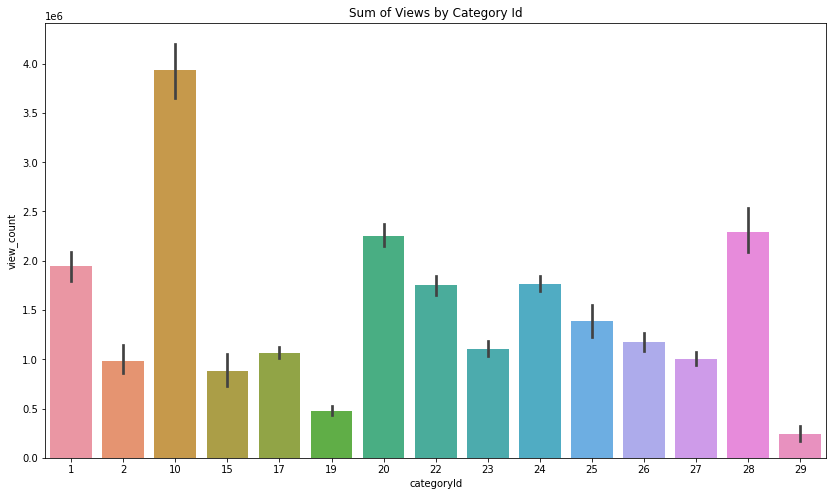

In [11]:
plt.figure(figsize=(14, 8))
sns.barplot(data=youtube, x='categoryId', y='view_count').set_title('Sum of Views by Category Id');

### Plot the Likes and Dislikes for Category Id

Its interesting point out that both in likes and dislikes the same categories ranking in overall.

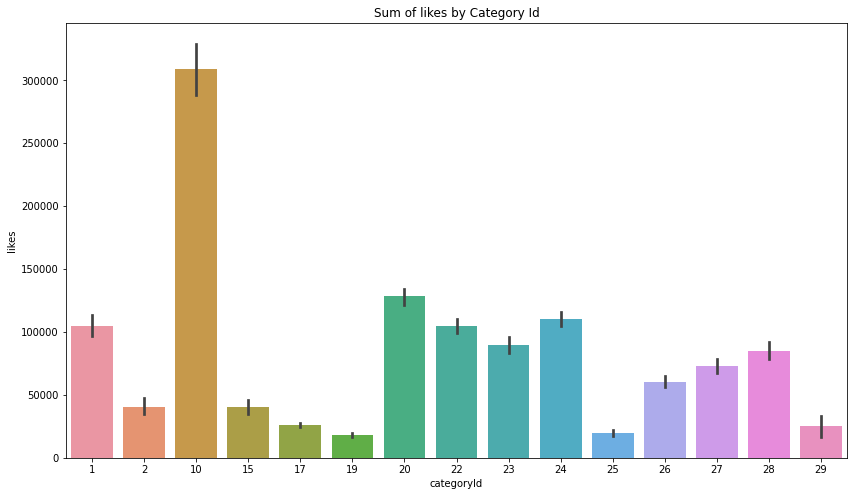

In [12]:
plt.figure(figsize=(14, 8))
sns.barplot(data=youtube, x='categoryId', y='likes').set_title('Sum of likes by Category Id');

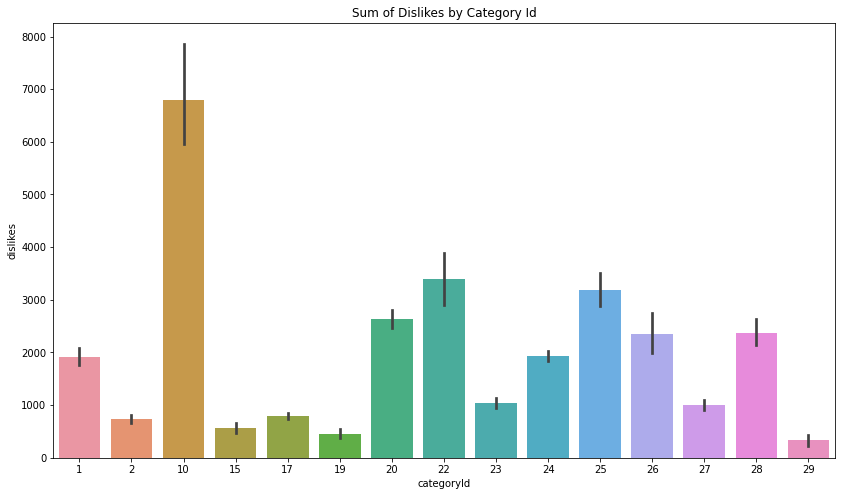

In [13]:
plt.figure(figsize=(14, 8))
sns.barplot(data=youtube, x='categoryId', y='dislikes').set_title('Sum of Dislikes by Category Id');

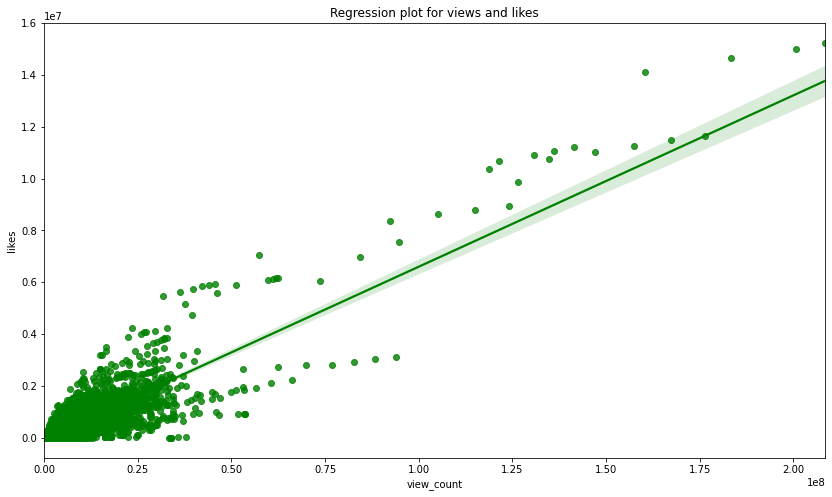

In [14]:
# Let's do a regression plot to see the relarionship between views and likes
plt.figure(figsize=(14, 8))
sns.regplot(data=youtube, x='view_count', y='likes', color='green')
plt.title('Regression plot for views and likes');

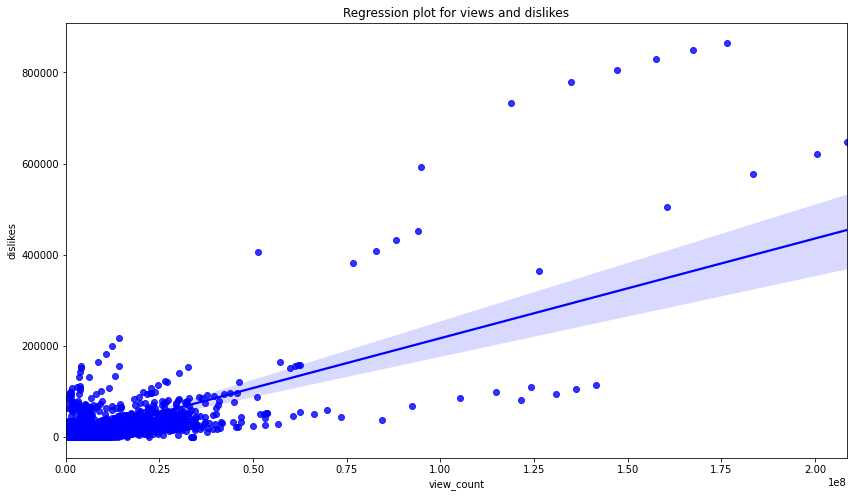

In [15]:
# Let's perform a regression plot to see the relarionship between views and dislikes
plt.figure(figsize=(14, 8))
sns.regplot(data=youtube, x='view_count', y='dislikes', color= 'blue')
plt.title('Regression plot for views and dislikes');

Compared the Regression plot for Likes against Dislikes, we can see that Likes follow a more linear line, and the Dislikes increase as the views increase.

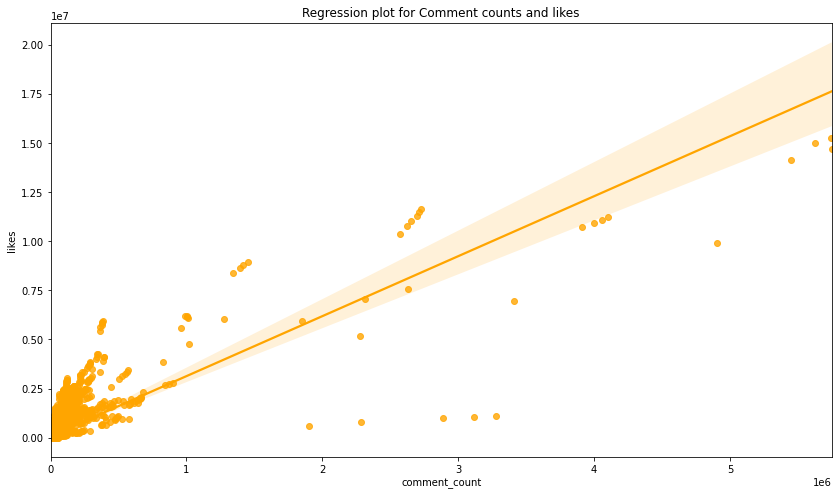

In [16]:
# Let's do a regression plot to see the relarionship between comment counts and likes
plt.figure(figsize=(14, 8))
sns.regplot(data = youtube, x='comment_count', y='likes', color='orange')
plt.title('Regression plot for Comment counts and likes');

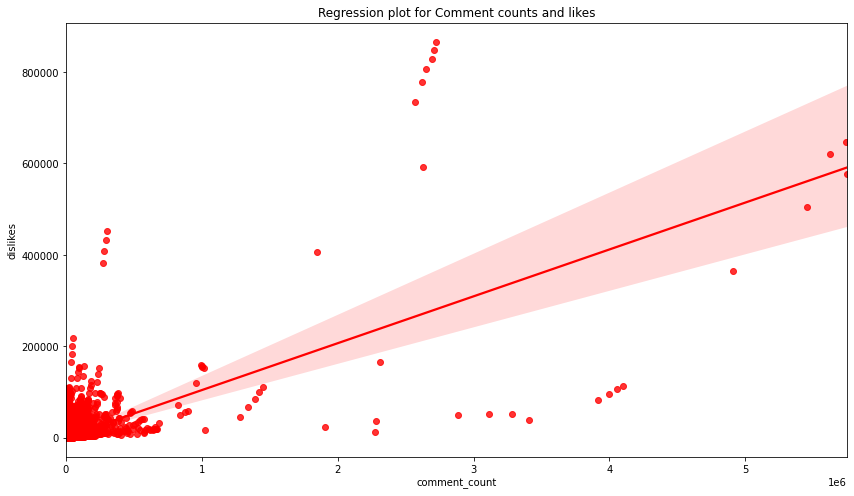

In [17]:
plt.figure(figsize=(14, 8))
sns.regplot(data = youtube, x='comment_count', y='dislikes', color='red')
plt.title('Regression plot for Comment counts and likes');

In [18]:
# Let's view our correlation table:likes, dislikes, views, and comments
df_corr = youtube[['likes', 'dislikes', 'comment_count', 'view_count']]
df_corr.corr()

,likes,dislikes,comment_count,view_count
likes,1.000000,0.715638,0.793403,0.892892
dislikes,0.715638,1.000000,0.674361,0.746385
comment_count,0.793403,0.674361,1.000000,0.730504
view_count,0.892892,0.746385,0.730504,1.000000


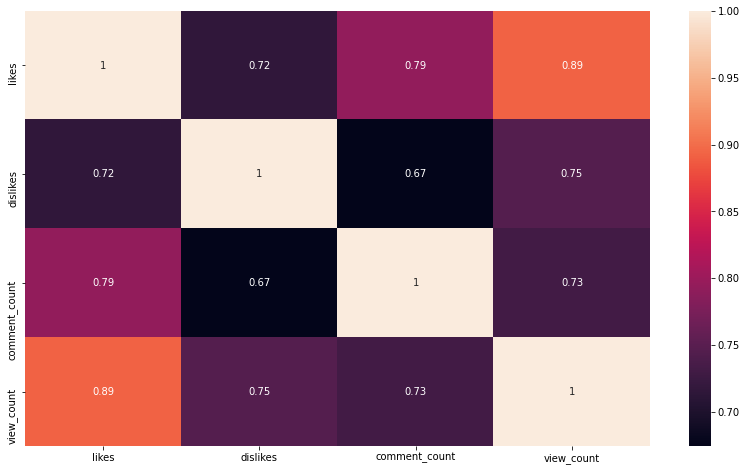

In [19]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_corr.corr(), annot= True);

Notice a high correlation between view_count and likes, and likes vs. Comment_count. That makes sense! people who like a video tend to leave a comment and vice versa. 

## Sentiment Analysis

In [20]:
# Display tags
youtube.tags.head(15)

0     jacksepticeye|funny|funny meme|memes|jacksepti...
1     eleanor|neale|eleanor neale|eleanor neale true...
2     Apex Legends|Apex Legends characters|new Apex ...
3     Nines|Trapper of the year|Crop Circle|Nines Tr...
4                                                [None]
5                      cgpgrey|education|hello internet
6                                                [None]
7     brawadis|prank|basketball|skits|ghost|funny vi...
8                                                [None]
9     The LaBrant Family|DIY|Interior Design|Makeove...
10    Football|Soccer|Onefootball|Football app|premi...
11    tifo football|tifo football youtube|youtube ti...
12                behzinga|beh2inga|sidemen|moresidemen
13    Fifa|fifa 21|fifa21|fifa 21 trailer|fifa 21 ne...
14    protests|seattle|local|news|carmen best|seattl...
Name: tags, dtype: object

## Lets check the tags that ost appear in the Tags

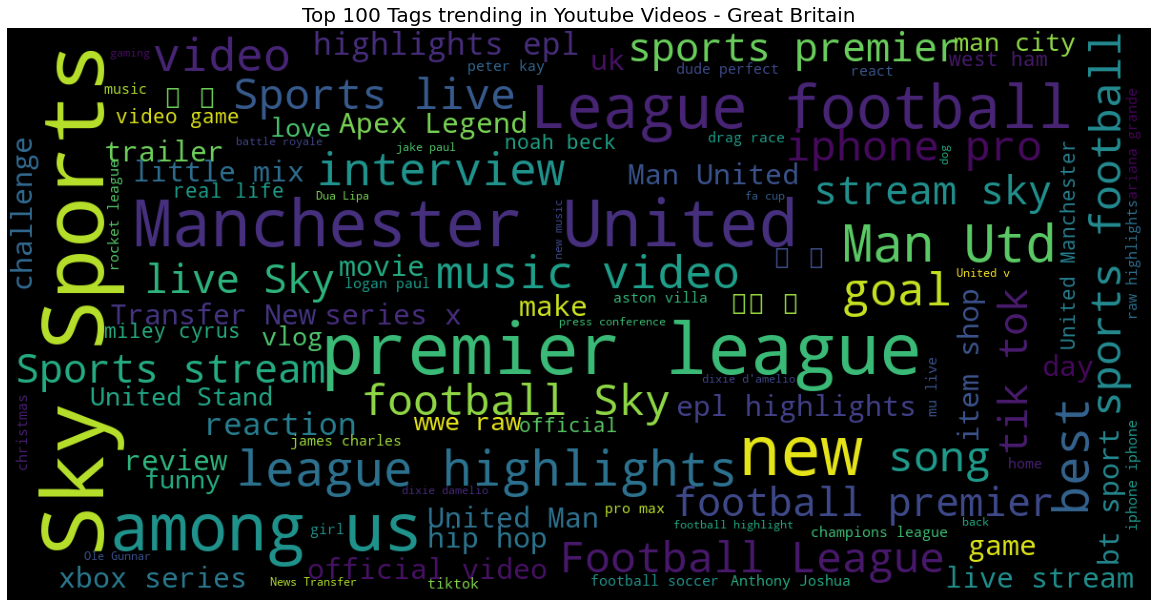

In [21]:
youtube_tags = youtube.copy()
#lets analyze the tags of trending videos
youtube_tags = remove_duplicate_title(youtube_tags,'last') #remove duplicate titles
youtube_tags = youtube_tags[['tags']]

#we'll ignore videos without tags and join tags with space using '-'
mask = youtube_tags['tags'] != '[None]'
youtube_tags = youtube_tags['tags'][mask].str.replace(' ','-').to_frame()
youtube_tags = youtube_tags['tags'][mask].str.replace('|',' ')

#prepare the tags for word processing
text = list(set(youtube_tags)) 
wordcloud = WordCloud(max_font_size=30,
                      background_color='black',
                      scale=3,
                      max_words=100
                     ).generate(str(text))

plt.figure(figsize=(28,22))
ax4 = plt.subplot2grid((4, 2), (2, 0), colspan=2,rowspan=2)
ax4.set_title('Top 100 Tags trending in Youtube Videos - Great Britain',fontsize=20)
ax4.imshow(wordcloud)
ax4.axis('off')
plt.show()

### Insight:
At the time of this analysis: we can see that the top 100 tags are from:
SKY Sports, Premier league, Manchester United, among us, new, Man Utd and league football. In other words seems that sports atre the youtube trend in Great Britan

## Discover the Top 10 Trending Channels

In [22]:
#top 10 repeat trended channels
trend_channel = youtube[['channelTitle']].\
    assign(trended_count= 1).\
    groupby(['channelTitle'], as_index=False).\
    count().\
    sort_values('trended_count',ascending=False).head(10).sort_values('trended_count')

In [23]:
#initialize interactive graph object
fig = go.Figure()

#add bar graph for top 10 repeat trended channels
fig.add_trace(go.Bar(x= trend_channel['trended_count'], y= trend_channel['channelTitle'],
                     orientation='h',marker=dict(color = '#228EB7')))

#update graph layout and add buttons for each trace
fig.update_layout({
    'title' : {
        'font_size' : 20,'text' : 'Top 10 Repeated Trending Channels'},
    'xaxis' : {
        'title' : {'text':'Number of Times Trended','font_size' : 16}},
    'yaxis' : {
        'title' : {'text' : 'Video Title','font_size' : 16}
    }})

fig.show()

We can see, the top 3 repeat trended Channels are related to sports: The United Stand video, SkySports Football and BT Sport.


## Extracting Features from Tags
Before we build the model for our sentiment analysis, it is required to convert the tags into vector formation as computer cannot understand words and their sentiment. In this project, we are going to use TF-TDF method to convert the texts

### Stemming the reviews
Stemming is a method of deriving root word from the inflected word. Here we extract the tags and convert the words in tags to its root word. 

Example:

Going->go

Finally->fina

If you notice, the root words doesn't need to carry a semantic meaning. There is another technique knows as Lemmatization where it converts the words into root words which has a semantic meaning.

In [24]:
#Extracting 'tags' for processing
tag_features=youtube.copy()
tag_features=tag_features[['tags']].reset_index(drop=True)
tag_features.head()

,tags
0,jacksepticeye|funny|funny meme|memes|jacksepti...
1,eleanor|neale|eleanor neale|eleanor neale true...
2,Apex Legends|Apex Legends characters|new Apex ...
3,Nines|Trapper of the year|Crop Circle|Nines Tr...
4,[None]


In [25]:
#Performing stemming on the Tag column
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(tag_features)):
    tags = re.sub('[^a-zA-Z]', ' ', tag_features['tags'][i])
    tags = tags.split()
    tags = ' '.join(tags)
    corpus.append(tags)   

In [26]:
corpus[3]

'Nines Trapper of the year Crop Circle Nines Trapper of the year Crop Circle nines Nines crop circle I see you shining Nines I see you shining High roller J Hus Nines J Hus Nines High Roller Nines Official Video Nines Video Nines Music Nines Freestyle Clout Nines Clout Crabs In A Bucket'

### To be continued....